### Environment Setup

Imports

In [ ]:
## This cell will install dask If not installed yet.
# If so please run this notebook again as soon as this cell
# finishes executing. 

try:
  import dask.dataframe as dd   
except ImportError:
  !pip install "dask[complete]" --upgrade
  print("dask installed\n\nPlease RUN this notebook again!")

  # Restarting runtime
  import os
  os.kill(os.getpid(), 9)

#----

#import dask.array as da
from dask.distributed import Client
from zipfile import ZipFile
import os, shutil

Montando o Google Drive

In [ ]:
## ATENÇÃO! Aparecerá um link externo seguro provido automaticamente pelo Google Colab para que seja 
## gerado o código de autenticação necessário para o acesso ao Drive.

if not os.path.exists('/content/drive'):
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


Setup dask client

In [ ]:
# Dask client setup (Colab RAM)
client = Client()
client

NVMLError_Uninitialized: ignored

Criando pasta para armazenamento dos dados

In [ ]:
if not os.path.exists('/content/DADOS/'):
  !mkdir '/content/DADOS/'

### Data Gathering

Unzipping data folder

In [5]:
def unzip_csv(ano):
  if not isinstance(ano, str):
    ano = str(ano)
  
  zipdata_path = f'/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Dados/microdados_enem_{ano}.zip'
  target_path  = f'/content/DADOS/MICRODADOS_ENEM_{ano}.csv'
  source_path  = f'DADOS/MICRODADOS_ENEM_{ano}.csv'

  if os.path.exists(target_path):
    return True

  # Os dados do ano de 2017 foram compactados de forma diferente:
  if ano == '2017':
    source_path = f'Microdados ENEM 2017/{source_path}'

  # Copiando apenas o arquivo .csv para a pasta destino sem todo o caminho
  # herdado do diretório
  with ZipFile(zipdata_path, 'r') as z:
    source = z.open(source_path)
    target = open(target_path, 'wb')

    with source, target:
      shutil.copyfileobj(source, target)

In [6]:
ano = 2019
unzip_csv(ano)

In [ ]:
data_path      = f'/content/DADOS/MICRODADOS_ENEM_{str(ano)}.csv'
temp_save_path = f'/content/DADOS/MICRODADOS_ENEM_{str(ano)}.pq'

Reading data into dask dataframe

In [ ]:
df = pd.read_csv(data_path, chunksize=1000000)

In [ ]:
%%time
if not os.path.exists(temp_save_path):
  # read from csv file
  df = dd.read_csv(data_path, sep=';', encoding='latin-1')
  # converto to parquet file
  df.to_parquet(temp_save_path)
  # read parquet file (more efficient)

df = dd.read_parquet(temp_save_path)
print(df.head())

   NU_INSCRICAO  NU_ANO  CO_MUNICIPIO_RESIDENCIA  ... Q023  Q024 Q025
0  190001004627    2019                  1506807  ...    A     B    A
1  190001004628    2019                  1504059  ...    A     A    A
2  190001004629    2019                  1505502  ...    A     C    B
3  190001004630    2019                  1507706  ...    A     A    A
4  190001004631    2019                  1503903  ...    A     A    A

[5 rows x 136 columns]
CPU times: user 461 ms, sys: 53.9 ms, total: 515 ms
Wall time: 3.17 s


Informações sobre o dataframe

In [ ]:
%%time
# Dataframe dimensions
print(f'Rows: {len(df):,}\nColumns: {df.shape[1]}\n')

Rows: 5,095,270
Columns: 136

CPU times: user 279 ms, sys: 30.1 ms, total: 309 ms
Wall time: 1.06 s


In [ ]:
%%time
print(f'Número de partições: {df.npartitions}')

Número de partições: 50
CPU times: user 1.34 ms, sys: 590 µs, total: 1.93 ms
Wall time: 2.58 ms


In [ ]:
%%time
# Partition Average Sizes 
df.map_partitions(len).compute().head()   # Takes longer than other cells due to compute() method

CPU times: user 2.42 s, sys: 283 ms, total: 2.71 s
Wall time: 29.7 s


0    101144
1     98143
2     99270
3     98463
4     98335
dtype: int64

In [ ]:
%%time
# Accessing partition 1 (second one)
df.get_partition(1).head()

CPU times: user 79 ms, sys: 7.41 ms, total: 86.5 ms
Wall time: 876 ms


,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,CO_MUNICIPIO_NASCIMENTO,NO_MUNICIPIO_NASCIMENTO,CO_UF_NASCIMENTO,SG_UF_NASCIMENTO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,CO_ESCOLA,CO_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,CO_UF_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_AUTISMO,IN_VISAO_MONOCULAR,...,TX_RESPOSTAS_CH,TX_RESPOSTAS_LC,TX_RESPOSTAS_MT,TP_LINGUA,TX_GABARITO_CN,TX_GABARITO_CH,TX_GABARITO_LC,TX_GABARITO_MT,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025
0,190001105773,2019,2201903,Bom Jesus,22,PI,16,F,1,3,1,2111607.0,São Raimundo das Mangabeiras,21.0,MA,2,0,2,1.0,0,22062670.0,2201903.0,Bom Jesus,22.0,PI,2.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,...,EDCADBACBDCEEBCCBAEDBBEDBACEBAECABEDBCBAEEBCD,CBDBD99999BCADBDABEEACAEBADCABECDEADCBABBDBDEA...,None,0,None,BACCCBABBADCBCEEEBCACACEEDBCCADBEADBADBBBACDB,BDABEABCADBCBAADDBECDAAECDAECBECBCCDEEAAADDBBC...,None,1.0,120.0,120.0,100.0,120.0,0.0,460.0,B,C,B,F,4,A,A,B,D,A,B,B,A,A,A,A,A,A,B,B,A,C,A,B,B
1,190001105774,2019,2211308,Valença do Piauí,22,PI,45,F,3,1,1,2211308.0,Valença do Piauí,22.0,PI,1,13,1,1.0,0,NaN,NaN,None,NaN,None,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,...,CBACACDBEBDADABAEDDEDEDBAEDEBACCCACEEBEEEBDCD,99999EDCEEDAEABCEAEBDBCDBEADDEAEDCDDDEECDCECAD...,DDAEDDDCDBDECADBDEEEDDEDADEBDCDDEDADDDDDDDEED,1,AAECACDEADCBCDDDBCBDADAEABCEBABEEBCBEECEBDADC,EEBCEEDBADBBCBABCCADCEBACDBBACCACACBEADBBADCB,ADBBEDCABAABBCBCDAAECDDDBAAAECADECDCEBDEEAECBD...,EEEADBEBACABCDBABECECACDCBDCCEDCDABEDECDDDBAA,1.0,140.0,120.0,120.0,120.0,80.0,580.0,A,A,A,A,2,B,A,B,C,A,A,B,A,A,A,A,A,A,B,A,A,C,A,A,B
2,190001105775,2019,2207504,Palmeirais,22,PI,18,M,1,1,1,2207504.0,Palmeirais,22.0,PI,2,0,2,1.0,0,22044752.0,2207504.0,Palmeirais,22.0,PI,2.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,...,AECCEBDEDBBDABABDBABEAEDCEBEEBBCCECDBADDABACB,99999EDABAEBDCBCECEECADCBCDACEBDDBDCDEDEBAEEEA...,EDCACDBBABADAAABBEDCCDCABCCEBEACBDCCDDECBACCE,1,AAECACDEADCBCDDDBCBDADAEABCEBABEEBCBEECEBDADC,EEBCEEDBADBBCBABCCADCEBACDBBACCACACBEADBBADCB,ADBBEDCABAABBCBCDAAECDDDBAAAECADECDCEBDEEAECBD...,EEEADBEBACABCDBABECECACDCBDCCEDCDABEDECDDDBAA,1.0,140.0,180.0,160.0,140.0,120.0,740.0,C,E,A,D,2,C,A,B,C,A,B,B,A,A,A,A,A,A,B,B,A,C,A,A,A
3,190001105776,2019,2203909,Floriano,22,PI,26,F,1,3,1,2203909.0,Floriano,22.0,PI,1,4,1,1.0,0,NaN,NaN,None,NaN,None,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,...,CAAABBDACACBDADAECDABAEACCDEABBCAEEECCADECCDA,99999AADCBCEDBBEECABCCCCDBAABAEBABDCAEEAEEDCEA...,DCDDBAECADBDBDBEBECBAABDACECACDCBCAADBBBDCDCE,1,DEADBAAAEBEECEBCBCBCBDADAEABCEDDDDADCBEECACBC,CBABADBBCEEEBCBADCBEEDBBEADBBACDBBACCCCADACAC,BBEDABDACACBABAECBBCCADCEBDBBCDDEEAAADDBECDECA...,AADDDBEEEBEDDBEBACABCDBABECECACAECDCBDCCEDCDA,1.0,120.0,40.0,40.0,80.0,0.0,280.0,H,E,F,C,3,B,A,B,C,A,B,B,A,A,A,A,A,A,B,A,A,B,A,A,B
4,190001105777,2019,2208304,Piracuruca,22,PI,18,F,1,3,1,2208304.0,Piracuruca,22.0,PI,2,0,2,1.0,0,22017011.0,2208304.0,Piracuruca,22.0,PI,2.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,...,CCBECBAEDDAAEEBACEDAAAEEACECEAEBEDECCDDCDABEE,99999EDAEEBBBBECACEECBEEDDACECBAEBDCEEEACCEEEA...,AABABDDCDBEAEECBADDCABAEEACEDEEDDEBAEAECACDAD,1,AAECACDEADCBCDDDBCBDADAEABCEBABEEBCBEECEBDADC,EEBCEEDBADBBCBABCCADCEBACDBBACCACACBEADBBADCB,ADBBEDCABAABBCBCDAAECDDDBAAAECADECDCEBDEEAECBD...,EEEADBEBACABCDBABECECACDCBDCCEDCDABEDECDDDBAA,1.0,100.0,120.0,120.0,100.0,40.0,480.0,B,D,F,B,6,B,A,B,C,A,A,B,A,A,A,A,A,A,B,A,A,B,A,A,B


Com *dask*, sempre que precisar utilizar alguma funcionalidade suportada apenas por *Pandas*, usa-se *compute()* - ou *len(dask_df)*, como acima - que "varre" todas as partições em que os dados foram armazenados. O tempo decorrido é inversamente proporcional ao espaço em memória RAM e ao número de "trabalhadores" utilizados (por padrão, igual ao número de núcleos presente no processador).

No Google Colab:

1.   Memória RAM alocável: **12,72 GB**

2.   Número de núcleos (*workers*) disponível: **2 núcleos**

Algumas operações podem tomar um certo tempo devido ao número relativamente baixo de núcleos no amiente virtual. Entretanto, é apreciado que seja possível ter todos os dados sem que a memória RAM seja sobrecarregada ou que sejam excluídas colunas antes mesmo de serem analisadas.

Para isso, tem-se 50 partições com aproximadamente 100 mil linhas de dados.



### Pré-processamento de Dados

*Roadmap*:

Manipulando colunas

*   TP_PRESENCA: 0 if any 0 in TP_PRESENCAs else 1  #ok
*   NU_NOTA_MEDIA: média das NU_NOTAs               #ok
*   Atendimento Especializado/Específico            #ok

Excluindo colunas

*   Colunas sobre escola com proporção de valores nulos muito alta (>50%?) #ok
*   Respostas, gabaritos, notas de competências e códigos de provas       #ok
*   Pertencentes a IN_SEM_RECURSO     #ok



#### Manipulando colunas

Agrupando dados espalhados em múltiplas colunas no menor número possível de counas a fim de reduzir as dimensões da base de dados.

**Coluna de Média de Notas**

Para dar simplicidade e objetividade ao algoritmo posteriormente, é interessante utilizar apenas uma colunas como alvo com relação às notas. Portanto, as notas serão representadas pela média de cada uma das 5 (cinco) áeras do conhecimento.

Além disso, todas as demais colunas relacionadas às notas (notas de competência na Redação, nota em cada cadernos de prova, folhas-resposta e gabaritos)

In [ ]:
cols_notas = ['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO']
df = df.assign(NU_NOTA_MEDIA = df[cols_notas].mean(axis=1, skipna=False))   
# Se quiser saber somente quantos não foram em nenhum dia, basta tirar o parâmetro skipna

**Coluna de Presença**

Se o inscrito constar ausência em algum ou em todos os dias será 
registrado como *TP_PRESENCA: False*. Dessa forma, a definição de ausente/desistente é obtida com maior clareza a partir de uma única coluna. Aquelas que serviram de base para se obter TP_PRESENCA serão excluídas.

In [ ]:
# Forma vetorizada - desempenho maior
#df['TP_PRESENCA'] = (
#    (df.TP_PRESENCA_CH==1) & (df.TP_PRESENCA_CN==1) & (df.TP_PRESENCA_LC==1) & (df.TP_PRESENCA_MT==1) & (df.TP_STATUS_REDACAO==1)
#)

df['TP_PRESENCA'] = ~df['NU_NOTA_MEDIA'].isna()
df['TP_PRESENCA'] = df['TP_PRESENCA'].astype(int)

In [ ]:
%%time
df['TP_PRESENCA'].value_counts().compute()  # o parâmetro normalize=True não tem suporte para Dask

CPU times: user 2.89 s, sys: 301 ms, total: 3.19 s
Wall time: 38.6 s


1    3702007
0    1393263
Name: TP_PRESENCA, dtype: int64

Em *pandas*, o método *value_counts* possui um parâmetro chamado *normalize* que retorna a frequência de cada valor. Em *Dask*, entretanto, não é suportado.

Sendo assim, realizando um cálculo manual. tem-se que a **razão de desistência ou ausência, em qualquer das cinco provas, é de 27,34%** 

**Coluna de Atendimento Especializado**

O INEP oferece opções de atendimento especializado que são dispostas em 13 colunas. Como compreendem uma pequena parte da composição, serão agrupadas em uma só coluna que indicará se o inscrito requisitou ou não algum atendimento especializado para o Exame.

In [ ]:
cols_especial = ['IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DEFICIENCIA_AUDITIVA',
                 'IN_SURDO_CEGUEIRA', 'IN_DEFICIENCIA_FISICA', 'IN_DEFICIENCIA_MENTAL',
                 'IN_DEFICIT_ATENCAO', 'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_AUTISMO',
                 'IN_VISAO_MONOCULAR', 'IN_OUTRA_DEF']

df = df.assign(IN_ATEND_ESPECIALIZADO = df.loc[:, cols_especial].max(1))

**Coluna de Atendimento Específico**

O Inep oferece opções de atendimento a condições específicas que são dispostas em 4 colunas. Como compreendem uma pequena parte da composição, serão agrupadas em uma só coluna que indicará se o inscrito requisitou ou não algum atendimento específico para o Exame.

In [ ]:
cols_especifico = ['IN_GESTANTE', 'IN_LACTANTE', 'IN_IDOSO', 'IN_ESTUDA_CLASSE_HOSPITALAR']
df = df.assign(IN_ATEND_ESPECIFICO = df.loc[:, cols_especifico].max(1))

In [ ]:
df.head()

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,CO_MUNICIPIO_NASCIMENTO,NO_MUNICIPIO_NASCIMENTO,CO_UF_NASCIMENTO,SG_UF_NASCIMENTO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,CO_ESCOLA,CO_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,CO_UF_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC,IN_BAIXA_VISAO,IN_CEGUEIRA,IN_SURDEZ,IN_DEFICIENCIA_AUDITIVA,IN_SURDO_CEGUEIRA,IN_DEFICIENCIA_FISICA,IN_DEFICIENCIA_MENTAL,IN_DEFICIT_ATENCAO,IN_DISLEXIA,IN_DISCALCULIA,IN_AUTISMO,IN_VISAO_MONOCULAR,...,TX_GABARITO_CN,TX_GABARITO_CH,TX_GABARITO_LC,TX_GABARITO_MT,TP_STATUS_REDACAO,NU_NOTA_COMP1,NU_NOTA_COMP2,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_COMP5,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,NU_NOTA_MEDIA,TP_PRESENCA,IN_ATEND_ESPECIALIZADO,IN_ATEND_ESPECIFICO
0,190001004627,2019,1506807,Santarém,15,PA,21,M,1,3,4,NaN,None,NaN,None,1,3,1,NaN,0,NaN,NaN,None,NaN,None,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,...,BEEAAEBEEBADEADDADAEABCEDDDBCBCBCCACBCDADCCEB,ACACEEBCCBABADBBBACDBBACCCCADCEBADCBEEDBBEADB,EBBADCABDABACBCEBDEEAAADDBECDECDDBADBCDAAECBCC...,BEDEEEAADBEBACABCDBABECECACADCBDCCEDCDABECDDD,1.0,160.0,160.0,160.0,140.0,160.0,780.0,D,E,A,A,7,B,A,B,C,A,A,B,A,B,A,A,A,A,C,B,A,D,A,B,A,517.06,1,0,0
1,190001004628,2019,1504059,Mãe do Rio,15,PA,16,F,1,3,1,1505502.0,Paragominas,15.0,PA,3,0,1,NaN,1,NaN,NaN,None,NaN,None,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,...,DEADBAAAEBEECEBCBCBCBDADAEABCEDDDDADCBEECACBC,EEBCEEDBADBBCBABCCADCEBACDBBACCACACBEADBBADCB,ADBBEDCABAABBCBCDAAECDDDBAAAECADECDCEBDEEAECBD...,AADDDBEEEBEDDBEBACABCDBABECECACAECDCBDCCEDCDA,1.0,120.0,120.0,120.0,120.0,120.0,600.0,D,E,A,A,5,B,A,B,C,A,A,B,A,B,A,A,A,A,B,B,A,B,A,A,A,470.62,1,0,0
2,190001004629,2019,1505502,Paragominas,15,PA,18,F,1,1,1,1505502.0,Paragominas,15.0,PA,2,0,3,1.0,0,15230023.0,1505502.0,Paragominas,15.0,PA,4.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,...,DADCCEBBCCACBEEBEEBACBCDDDDADBCBBCEAEADEADAAE,EEBCEEDBADBBCBABCCADCEBACDBBACCACACBEADBBADCB,ADBBEDCABAABBCBCDAAECDDDBAAAECADECDCEBDEEAECBD...,DBEBACABCDBABECEEEDCBDCCEDCDABEDAADDDECACAECB,1.0,140.0,120.0,120.0,140.0,120.0,640.0,H,E,A,D,3,C,D,E,E,C,A,B,C,B,A,B,A,A,D,B,B,D,A,C,B,581.40,1,0,0
3,190001004630,2019,1507706,São Sebastião da Boa Vista,15,PA,23,M,0,3,1,1501402.0,Belém,15.0,PA,2,0,2,1.0,0,15027635.0,1507706.0,São Sebastião da Boa Vista,15.0,PA,2.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,...,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D,D,A,B,3,C,A,B,C,A,A,B,A,A,A,A,A,A,C,A,A,D,A,A,A,NaN,0,0,0
4,190001004631,2019,1503903,Juruti,15,PA,23,M,1,3,1,1503903.0,Juruti,15.0,PA,1,5,1,1.0,0,NaN,NaN,None,NaN,None,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,...,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B,C,A,A,5,C,A,C,B,A,B,B,A,B,A,A,A,A,B,A,A,D,A,A,A,NaN,0,0,0


#### Excluindo colunas

**Colunas de Presenças, Notas, Atendimento Especializado e Antendimento Específico**

Após ter reunidas as informações de tantas colunas em um número bem menor, pode-se, agora, excluír essas colunas sem que se perca informação relevante e, assim, reduzir as dimensões da base de dados.

In [ ]:
cols_presenca = ['TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT', 'TP_STATUS_REDACAO']
cols_notas    = ['CO_PROVA_CN', 'TP_LINGUA', 'CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_MT', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2',
                 'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'TX_RESPOSTAS_CN', 'TX_RESPOSTAS_CH', 'TX_RESPOSTAS_LC',
                 'TX_RESPOSTAS_MT', 'TX_GABARITO_CN', 'TX_GABARITO_CH', 'TX_GABARITO_LC', 'TX_GABARITO_MT']
cols_to_delete = cols_presenca + cols_notas + cols_especial + cols_especifico
#print(cols_to_delete)

df = df.drop(cols_to_delete, axis=1)

In [ ]:
# Por alguma razão, é necessário excluir estas colunas separadamente
# Se excluir junto com as demais, os valores da média de notas se alteram       ## Checar motivo

# Decidou NÃO EXCLUIR a nota da REDAÇÃO
df = df.drop(['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT'], axis=1)

In [ ]:
df.head()

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,CO_MUNICIPIO_NASCIMENTO,NO_MUNICIPIO_NASCIMENTO,CO_UF_NASCIMENTO,SG_UF_NASCIMENTO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,CO_ESCOLA,CO_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,CO_UF_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC,IN_SEM_RECURSO,IN_BRAILLE,IN_AMPLIADA_24,IN_AMPLIADA_18,IN_LEDOR,IN_ACESSO,IN_TRANSCRICAO,IN_LIBRAS,IN_TEMPO_ADICIONAL,IN_LEITURA_LABIAL,IN_MESA_CADEIRA_RODAS,IN_MESA_CADEIRA_SEPARADA,...,IN_SALA_INDIVIDUAL,IN_SALA_ESPECIAL,IN_SALA_ACOMPANHANTE,IN_MOBILIARIO_ESPECIFICO,IN_MATERIAL_ESPECIFICO,IN_NOME_SOCIAL,CO_MUNICIPIO_PROVA,NO_MUNICIPIO_PROVA,CO_UF_PROVA,SG_UF_PROVA,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,NU_NOTA_MEDIA,TP_PRESENCA,IN_ATEND_ESPECIALIZADO,IN_ATEND_ESPECIFICO
0,190001004627,2019,1506807,Santarém,15,PA,21,M,1,3,4,NaN,None,NaN,None,1,3,1,NaN,0,NaN,NaN,None,NaN,None,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1506807,Santarém,15,PA,780.0,D,E,A,A,7,B,A,B,C,A,A,B,A,B,A,A,A,A,C,B,A,D,A,B,A,517.06,1,0,0
1,190001004628,2019,1504059,Mãe do Rio,15,PA,16,F,1,3,1,1505502.0,Paragominas,15.0,PA,3,0,1,NaN,1,NaN,NaN,None,NaN,None,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1504059,Mãe do Rio,15,PA,600.0,D,E,A,A,5,B,A,B,C,A,A,B,A,B,A,A,A,A,B,B,A,B,A,A,A,470.62,1,0,0
2,190001004629,2019,1505502,Paragominas,15,PA,18,F,1,1,1,1505502.0,Paragominas,15.0,PA,2,0,3,1.0,0,15230023.0,1505502.0,Paragominas,15.0,PA,4.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1505502,Paragominas,15,PA,640.0,H,E,A,D,3,C,D,E,E,C,A,B,C,B,A,B,A,A,D,B,B,D,A,C,B,581.40,1,0,0
3,190001004630,2019,1507706,São Sebastião da Boa Vista,15,PA,23,M,0,3,1,1501402.0,Belém,15.0,PA,2,0,2,1.0,0,15027635.0,1507706.0,São Sebastião da Boa Vista,15.0,PA,2.0,1.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1507706,São Sebastião da Boa Vista,15,PA,NaN,D,D,A,B,3,C,A,B,C,A,A,B,A,A,A,A,A,A,C,A,A,D,A,A,A,NaN,0,0,0
4,190001004631,2019,1503903,Juruti,15,PA,23,M,1,3,1,1503903.0,Juruti,15.0,PA,1,5,1,1.0,0,NaN,NaN,None,NaN,None,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1503903,Juruti,15,PA,NaN,B,C,A,A,5,C,A,C,B,A,B,B,A,B,A,A,A,A,B,A,A,D,A,A,A,NaN,0,0,0


**Colunas de Recursos Especiais e Específicos**

O Inep oferece, ainda, a opção do inscrito solicitar algum recurso especializado ou específico, como prova em Braille, protetor auricular, intérpretes, leito para realizar prova deitado, entre outros.

Existe, porém, na base de dados fornecida pelo MEC/Inep, a coluna *IN_SEM_RECURSO* que já informa se o inscrito solicitou ou não algum desses recursos e, portanto, não foi necessário reunir os dados de todas as colunas relacionadas a esse indicador para uma única coluna como foi feito acima com os outros indicadores.

Desta forma, entende-se por necessário manter apensas a coluna *IN_SEM_RECURSO* e excluir as outras, visto que nela já estão contidas todas as informações relevantes para o estudo.

In [ ]:
cols_recurso = ['IN_BRAILLE', 'IN_AMPLIADA_24', 'IN_AMPLIADA_18', 'IN_LEDOR', 'IN_ACESSO',
                'IN_TRANSCRICAO', 'IN_LIBRAS', 'IN_TEMPO_ADICIONAL', 'IN_LEITURA_LABIAL',
                'IN_MESA_CADEIRA_RODAS', 'IN_MESA_CADEIRA_SEPARADA', 'IN_APOIO_PERNA',
                'IN_GUIA_INTERPRETE', 'IN_COMPUTADOR', 'IN_CADEIRA_ESPECIAL',
                'IN_CADEIRA_CANHOTO', 'IN_CADEIRA_ACOLCHOADA', 'IN_PROVA_DEITADO',
                'IN_MOBILIARIO_OBESO', 'IN_LAMINA_OVERLAY', 'IN_PROTETOR_AURICULAR',
                'IN_MEDIDOR_GLICOSE', 'IN_MAQUINA_BRAILE', 'IN_SOROBAN', 'IN_MARCA_PASSO',
                'IN_SONDA', 'IN_MEDICAMENTOS', 'IN_SALA_INDIVIDUAL', 'IN_SALA_ESPECIAL',
                'IN_SALA_ACOMPANHANTE', 'IN_MOBILIARIO_ESPECIFICO', 'IN_MATERIAL_ESPECIFICO',
                'IN_NOME_SOCIAL']

df = df.drop(cols_recurso, axis=1, errors='ignore')

In [ ]:
df.head()   # Já é possível ver todas as colunas do dataframe sem cortes/pulos

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,CO_MUNICIPIO_NASCIMENTO,NO_MUNICIPIO_NASCIMENTO,CO_UF_NASCIMENTO,SG_UF_NASCIMENTO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,TP_ENSINO,IN_TREINEIRO,CO_ESCOLA,CO_MUNICIPIO_ESC,NO_MUNICIPIO_ESC,CO_UF_ESC,SG_UF_ESC,TP_DEPENDENCIA_ADM_ESC,TP_LOCALIZACAO_ESC,TP_SIT_FUNC_ESC,IN_SEM_RECURSO,CO_MUNICIPIO_PROVA,NO_MUNICIPIO_PROVA,CO_UF_PROVA,SG_UF_PROVA,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,NU_NOTA_MEDIA,TP_PRESENCA,IN_ATEND_ESPECIALIZADO,IN_ATEND_ESPECIFICO
0,190001004627,2019,1506807,Santarém,15,PA,21,M,1,3,4,NaN,None,NaN,None,1,3,1,NaN,0,NaN,NaN,None,NaN,None,NaN,NaN,NaN,0,1506807,Santarém,15,PA,780.0,D,E,A,A,7,B,A,B,C,A,A,B,A,B,A,A,A,A,C,B,A,D,A,B,A,517.06,1,0,0
1,190001004628,2019,1504059,Mãe do Rio,15,PA,16,F,1,3,1,1505502.0,Paragominas,15.0,PA,3,0,1,NaN,1,NaN,NaN,None,NaN,None,NaN,NaN,NaN,0,1504059,Mãe do Rio,15,PA,600.0,D,E,A,A,5,B,A,B,C,A,A,B,A,B,A,A,A,A,B,B,A,B,A,A,A,470.62,1,0,0
2,190001004629,2019,1505502,Paragominas,15,PA,18,F,1,1,1,1505502.0,Paragominas,15.0,PA,2,0,3,1.0,0,15230023.0,1505502.0,Paragominas,15.0,PA,4.0,1.0,1.0,0,1505502,Paragominas,15,PA,640.0,H,E,A,D,3,C,D,E,E,C,A,B,C,B,A,B,A,A,D,B,B,D,A,C,B,581.40,1,0,0
3,190001004630,2019,1507706,São Sebastião da Boa Vista,15,PA,23,M,0,3,1,1501402.0,Belém,15.0,PA,2,0,2,1.0,0,15027635.0,1507706.0,São Sebastião da Boa Vista,15.0,PA,2.0,1.0,1.0,0,1507706,São Sebastião da Boa Vista,15,PA,NaN,D,D,A,B,3,C,A,B,C,A,A,B,A,A,A,A,A,A,C,A,A,D,A,A,A,NaN,0,0,0
4,190001004631,2019,1503903,Juruti,15,PA,23,M,1,3,1,1503903.0,Juruti,15.0,PA,1,5,1,1.0,0,NaN,NaN,None,NaN,None,NaN,NaN,NaN,0,1503903,Juruti,15,PA,NaN,B,C,A,A,5,C,A,C,B,A,B,B,A,B,A,A,A,A,B,A,A,D,A,A,A,NaN,0,0,0


**Verificando a frequência de valores nulos**

In [ ]:
%%time
# Might take a little long - 2x compute() and 1x len(dask_df)
df_columns_with_nan = df[df.columns[df.isna().any().compute()]]  # Parte do dataframe original apenas com as colunas que contem valores nulos
df_nan = df_columns_with_nan.isna().sum().compute().to_frame()   # Dataframe com a soma de valores nulos de cada coluna de df_withnan

df_nan.rename(columns={0: 'Quantidade'}, inplace=True)
df_nan['Porcentagem'] = 100*df_nan['Quantidade']/len(df_columns_with_nan)

CPU times: user 11.4 s, sys: 1.26 s, total: 12.6 s
Wall time: 2min 34s


In [ ]:
df_nan

,Quantidade,Porcentagem
CO_MUNICIPIO_NASCIMENTO,145249,2.850663
NO_MUNICIPIO_NASCIMENTO,145249,2.850663
CO_UF_NASCIMENTO,145249,2.850663
SG_UF_NASCIMENTO,145249,2.850663
TP_ENSINO,2217073,43.512375
CO_ESCOLA,3947858,77.480840
CO_MUNICIPIO_ESC,3947858,77.480840
NO_MUNICIPIO_ESC,3947858,77.480840
CO_UF_ESC,3947858,77.480840
SG_UF_ESC,3947858,77.480840


Porcentagem de dados faltantes a respeito das escolas em cada estado brasileiro

In [ ]:
import pandas as pd

In [ ]:
%%time
esc_uf = df.groupby('SG_UF_PROVA')['SG_UF_ESC']
esc_uf.count().head(27)

CPU times: user 4 s, sys: 415 ms, total: 4.42 s
Wall time: 51.4 s


In [ ]:
%%time
ausencia_esc_uf_pct = pd.crosstab(
    df['SG_UF_PROVA'],df['SG_UF_ESC'].fillna('NaN'), colnames=['UF_ESC'], rownames=['UF_PROVA']
)

CPU times: user 30 s, sys: 4.36 s, total: 34.4 s
Wall time: 5min 30s


In [ ]:
ausencia_esc_uf_pct  = ausencia_esc_uf_pct.apply(lambda x: x/x.sum()*100, axis=1)

stacked_esc = ausencia_esc_uf_pct.reset_index().rename(columns={'NaN':'value'})
stacked_esc = stacked_esc.sort_values(by='value', ascending=False)

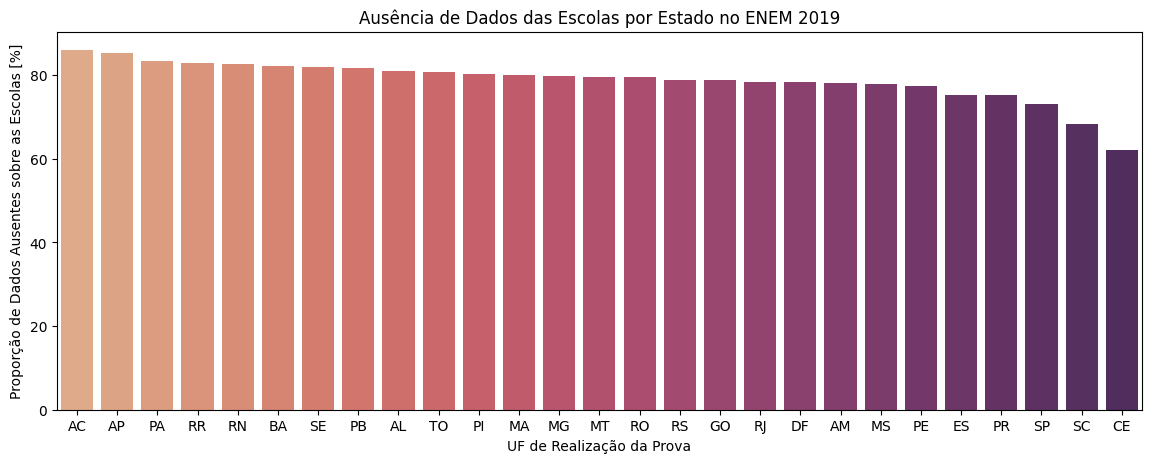

In [ ]:
# plot grouped bar chart
fig = plt.figure(figsize=(14,5), dpi=100)
sns.barplot(
    x='UF_PROVA', y='value', 
    data=stacked_esc,
    palette='flare'
)
plt.title(f'Ausência de Dados das Escolas por Estado no ENEM {str(ano)}')
plt.xlabel('UF de Realização da Prova')
plt.ylabel('Proporção de Dados Ausentes sobre as Escolas [%]')
plt.show()

Teste com Plotly

In [ ]:
import plotly.express as px
#import plotly.graph_objects as go

In [ ]:
fig = px.bar(
    stacked_esc, x='UF_PROVA', y='value',
    text = 'value',
    labels={
        'value': 'Dados Ausentes [%]',
        'UF_PROVA': 'Estado'},
    height=600, width=1200,
    title=f'Percentual de Dados Ausentes sobre as Escolas por Estado do Brasil no ENEM {str(ano)}'
    )
#fig.update_layout(
#    font_family="Courier New",
#    font_color="blue",
#    title_font_family="Times New Roman",
#    title_font_color="red"
#)
fig.update_layout(
    title={
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'}    
)
fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.show()

É possível observar que diversas informações sobre as escolas estão com uma taxa de omissão muito alta (aproximadamente 77% dos dados totais estão faltantes). 

Como não há uma notável diferença de proporção entre os estados, não é possível inferir nenhuma relação tampouco tomar qualquer decisão baseada nesses dados, já que fica muito difícil de substituí-los ou deletar os inscritos sem esses dados. 

Excluindo as colunas de dados sobre as escolas

In [ ]:
columns_to_drop = ['CO_ESCOLA', 'CO_MUNICIPIO_ESC', 'NO_MUNICIPIO_ESC', 'CO_UF_ESC', 'SG_UF_ESC',
                   'TP_DEPENDENCIA_ADM_ESC', 'TP_LOCALIZACAO_ESC', 'TP_SIT_FUNC_ESC', 'TP_ENSINO']
df = df.drop(labels=columns_to_drop, axis=1, errors='ignore')

In [ ]:
df.head()

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,CO_MUNICIPIO_NASCIMENTO,NO_MUNICIPIO_NASCIMENTO,CO_UF_NASCIMENTO,SG_UF_NASCIMENTO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,IN_TREINEIRO,IN_SEM_RECURSO,CO_MUNICIPIO_PROVA,NO_MUNICIPIO_PROVA,CO_UF_PROVA,SG_UF_PROVA,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,NU_NOTA_MEDIA,TP_PRESENCA,IN_ATEND_ESPECIALIZADO,IN_ATEND_ESPECIFICO
0,190001004627,2019,1506807,Santarém,15,PA,21,M,1,3,4,NaN,None,NaN,None,1,3,1,0,0,1506807,Santarém,15,PA,780.0,D,E,A,A,7,B,A,B,C,A,A,B,A,B,A,A,A,A,C,B,A,D,A,B,A,517.06,1,0,0
1,190001004628,2019,1504059,Mãe do Rio,15,PA,16,F,1,3,1,1505502.0,Paragominas,15.0,PA,3,0,1,1,0,1504059,Mãe do Rio,15,PA,600.0,D,E,A,A,5,B,A,B,C,A,A,B,A,B,A,A,A,A,B,B,A,B,A,A,A,470.62,1,0,0
2,190001004629,2019,1505502,Paragominas,15,PA,18,F,1,1,1,1505502.0,Paragominas,15.0,PA,2,0,3,0,0,1505502,Paragominas,15,PA,640.0,H,E,A,D,3,C,D,E,E,C,A,B,C,B,A,B,A,A,D,B,B,D,A,C,B,581.40,1,0,0
3,190001004630,2019,1507706,São Sebastião da Boa Vista,15,PA,23,M,0,3,1,1501402.0,Belém,15.0,PA,2,0,2,0,0,1507706,São Sebastião da Boa Vista,15,PA,NaN,D,D,A,B,3,C,A,B,C,A,A,B,A,A,A,A,A,A,C,A,A,D,A,A,A,NaN,0,0,0
4,190001004631,2019,1503903,Juruti,15,PA,23,M,1,3,1,1503903.0,Juruti,15.0,PA,1,5,1,0,0,1503903,Juruti,15,PA,NaN,B,C,A,A,5,C,A,C,B,A,B,B,A,B,A,A,A,A,B,A,A,D,A,A,A,NaN,0,0,0


Com relação à **localidade de nascimento**, há duas opções viáveis:

1.   Caso uma parte considerável dos inscritos possuam UF e/ou código de município de nascimento diferente do de residência, talvez possa ser interessante guardar essa informação em uma coluna estilo "TP_MOVIMENTO" e cabe alguma análise de alguma diferença de desempenho ou correlação com algum outro indicador, como renda familiar ou UF de destino, por exemplo.

2.   Caso contrário, considera-se que a localidade permanece a mesma e pode ser desconsiderada qualquer coluna relacionada às localidades de nascimento e residência, tomando como base de geolocalização apenas a UF onde foi realizada a prova.

In [ ]:
%%time
# Proporção de pessoas que mudaram de estado
n = len(df[df['SG_UF_NASCIMENTO']!=df['SG_UF_RESIDENCIA']])
print('Pessoas que se mudaram de estado desde que nasceram:\nQuantidade: {}\t{:.2f}%'.format(n, 100*n/len(df)))

Pessoas que se mudaram de estado desde que nasceram:
Quantidade: 645568	12.67%
CPU times: user 8.64 s, sys: 15.6 s, total: 24.2 s
Wall time: 1min 59s


In [ ]:
%%time
# Proporção de pessoas que mudaram de município
n = len(df[df['CO_MUNICIPIO_NASCIMENTO']!=df['CO_MUNICIPIO_RESIDENCIA']])
print('Pessoas que se mudaram de cidade desde que nasceram:\nQuantidade: {}\t{:.2f}%'.format(n, 100*n/len(df)))

Pessoas que se mudaram de cidade desde que nasceram:
Quantidade: 1604364	31.49%
CPU times: user 9.35 s, sys: 15.6 s, total: 25 s
Wall time: 2min 10s


Os valores nulos serão substituídos pela maior frequência da maior, ou seja, manter-se-á a mesma localidade, mas observando que há uma proporção significativa de inscritos que se mudaram de cidade e Unidade da Federação.

Por conta disso, talvez seja interessante guardar essa informação para eventuais análises.

In [ ]:
df['CO_MUNICIPIO_NASCIMENTO'] = df['CO_MUNICIPIO_NASCIMENTO'].fillna(value=df['CO_MUNICIPIO_PROVA'], axis=0)
df['NO_MUNICIPIO_NASCIMENTO'] = df['NO_MUNICIPIO_NASCIMENTO'].fillna(value=df['NO_MUNICIPIO_PROVA'], axis=0)
df['CO_UF_NASCIMENTO'] = df['CO_UF_NASCIMENTO'].fillna(value=df['CO_UF_PROVA'], axis=0)
df['SG_UF_NASCIMENTO'] = df['SG_UF_NASCIMENTO'].fillna(value=df['SG_UF_PROVA'], axis=0)

In [ ]:
df['TP_UF_MUDANCA'] = (df['CO_UF_NASCIMENTO']!=df['CO_UF_PROVA']) | (df['CO_UF_RESIDENCIA']!=df['CO_UF_NASCIMENTO'])
df['TP_UF_MUDANCA'] = df['TP_UF_MUDANCA'].astype(int)
df['TP_MUNICIPIO_MUDANCA'] = (df['CO_MUNICIPIO_NASCIMENTO']!=df['CO_MUNICIPIO_PROVA']) | (df['CO_MUNICIPIO_RESIDENCIA']!=df['CO_MUNICIPIO_NASCIMENTO'])
df['TP_MUNICIPIO_MUDANCA'] = df['TP_MUNICIPIO_MUDANCA'].astype(int)

In [ ]:
df.head()

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,CO_MUNICIPIO_NASCIMENTO,NO_MUNICIPIO_NASCIMENTO,CO_UF_NASCIMENTO,SG_UF_NASCIMENTO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,IN_TREINEIRO,IN_SEM_RECURSO,CO_MUNICIPIO_PROVA,NO_MUNICIPIO_PROVA,CO_UF_PROVA,SG_UF_PROVA,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,NU_NOTA_MEDIA,TP_PRESENCA,IN_ATEND_ESPECIALIZADO,IN_ATEND_ESPECIFICO,TP_UF_MUDANCA,TP_MUNICIPIO_MUDANCA
0,190001004627,2019,1506807,Santarém,15,PA,21,M,1,3,4,1506807.0,Santarém,15.0,PA,1,3,1,0,0,1506807,Santarém,15,PA,780.0,D,E,A,A,7,B,A,B,C,A,A,B,A,B,A,A,A,A,C,B,A,D,A,B,A,517.06,1,0,0,0,0
1,190001004628,2019,1504059,Mãe do Rio,15,PA,16,F,1,3,1,1505502.0,Paragominas,15.0,PA,3,0,1,1,0,1504059,Mãe do Rio,15,PA,600.0,D,E,A,A,5,B,A,B,C,A,A,B,A,B,A,A,A,A,B,B,A,B,A,A,A,470.62,1,0,0,0,1
2,190001004629,2019,1505502,Paragominas,15,PA,18,F,1,1,1,1505502.0,Paragominas,15.0,PA,2,0,3,0,0,1505502,Paragominas,15,PA,640.0,H,E,A,D,3,C,D,E,E,C,A,B,C,B,A,B,A,A,D,B,B,D,A,C,B,581.40,1,0,0,0,0
3,190001004630,2019,1507706,São Sebastião da Boa Vista,15,PA,23,M,0,3,1,1501402.0,Belém,15.0,PA,2,0,2,0,0,1507706,São Sebastião da Boa Vista,15,PA,NaN,D,D,A,B,3,C,A,B,C,A,A,B,A,A,A,A,A,A,C,A,A,D,A,A,A,NaN,0,0,0,0,1
4,190001004631,2019,1503903,Juruti,15,PA,23,M,1,3,1,1503903.0,Juruti,15.0,PA,1,5,1,0,0,1503903,Juruti,15,PA,NaN,B,C,A,A,5,C,A,C,B,A,B,B,A,B,A,A,A,A,B,A,A,D,A,A,A,NaN,0,0,0,0,0


#### Colunas "Extras"

Algumas colunas foram formatadas pelo Inep de forma a representar dados não informados com "1". Por isso, muitas não são detectadas com *isna()* e é preciso abordá-las individualmente de acordo com o Dicionário dos Microdados fornecido também pelo Inep.

Entre as que ainda estão presentes no Dataframe, constituem esse grupo:

*   TP_COR_RACA
*   TP_NACIONALIDADE
*   TP_ANO_CONCLUIU
*   TP_ESCOLA

Sendo assim, a começar por **TP_COR_RACA**, realiza-se uma análise de cada uma dessas colunas para ser decidido como serão tratados os dados que os inscritos escolheram não responder. Para isso, tenha-se que "0 = Não declarado"

In [ ]:
df['TP_COR_RACA'].value_counts().compute()

3    2364063
1    1831779
2     648309
4     116162
0     103201
5      31756
Name: TP_COR_RACA, dtype: int64

É possível observar que aqueles que escolheram não declarar ou não se sentiram representados pelas outras alternativas não representam, necessariamente, um grupo de dados faltantes. É possível tomar como um grupo como os outros.

A coluna deve, então, permanecer da mesma forma.

Já com  **TP_NACIONALIDADE**, dado que "0 = Não informado", tem-se:


In [ ]:
%%time
df['TP_NACIONALIDADE'].value_counts().compute()

CPU times: user 4.63 s, sys: 7.05 s, total: 11.7 s
Wall time: 1min 3s


1    4950021
2     124332
4       8233
0       6749
3       5935
Name: TP_NACIONALIDADE, dtype: int64

A proporção daqueles que não informaram não representam relevância perante os outros dados. Como a grande maioria é "1 = Brasileiro(a)", substituir-se-á todos zeros por um.

In [ ]:
df['TP_NACIONALIDADE'] = df['TP_NACIONALIDADE'].replace(0,1)

Para a **coluna TP_ANO_CONCLUIU**, com "0 = Não informado", tem-se:

In [ ]:
df['TP_ANO_CONCLUIU'].value_counts().compute()

0     2203392
1      660960
2      447324
13     405376
3      307227
4      232860
5      182887
6      144797
7      123774
8       97015
9       88481
10      78232
11      63817
12      59128
Name: TP_ANO_CONCLUIU, dtype: int64

Aqueles que não concluíram o Ensino Médio ainda também marcaram "0" nesse item do formulário. Apesar de haver alguns inscritos que marcaram desta forma mesmo assinalando no item anterior (TP_ST_CONCLUSAO) que já haviam concluído o Ensino Médio, viu desnecessário distinguí-los, visto que representam uma quantidade pequena com relação ao todo.

Além disso, aproveita-se para fazer a seguinte alocação:

*   Serão agrupados todos aqueles que concluíram o Ensino Médio a 10 (dez) anos ou mais antes de realizarem o respectivo Exame, ou seja, os valores da coluna TP_ANO_CONCLUIU maiores que 10 serão substituídos por 10.

Desta forma, obtem-se uma clusterização mais "arredondada" mas que mantém a informação relevante.

In [ ]:
condition = df['TP_ANO_CONCLUIU'] > 10
df['TP_ANO_CONCLUIU'] = df['TP_ANO_CONCLUIU'].mask(condition, 10)

Com relação à **coluna TP_ESCOLA**, sendo "1 = Não Respondeu": 



In [ ]:
df['TP_ESCOLA'].value_counts().compute()

1    3629376
2    1247262
3     218632
Name: TP_ESCOLA, dtype: int64

Devido ao número muito grande de inscritos que não responderam, será mantida esta coluna de forma que o grupo que respondeu possa ser agrupado na etapa de Análise Exploratória.

In [ ]:
df.head()

,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,CO_MUNICIPIO_NASCIMENTO,NO_MUNICIPIO_NASCIMENTO,CO_UF_NASCIMENTO,SG_UF_NASCIMENTO,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,IN_TREINEIRO,IN_SEM_RECURSO,CO_MUNICIPIO_PROVA,NO_MUNICIPIO_PROVA,CO_UF_PROVA,SG_UF_PROVA,NU_NOTA_REDACAO,Q001,Q002,Q003,Q004,Q005,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,NU_NOTA_MEDIA,TP_PRESENCA,IN_ATEND_ESPECIALIZADO,IN_ATEND_ESPECIFICO,TP_UF_MUDANCA,TP_MUNICIPIO_MUDANCA
0,190001004627,2019,1506807,Santarém,15,PA,21,M,1,3,4,1506807.0,Santarém,15.0,PA,1,3,1,0,0,1506807,Santarém,15,PA,780.0,D,E,A,A,7,B,A,B,C,A,A,B,A,B,A,A,A,A,C,B,A,D,A,B,A,517.06,1,0,0,0,0
1,190001004628,2019,1504059,Mãe do Rio,15,PA,16,F,1,3,1,1505502.0,Paragominas,15.0,PA,3,0,1,1,0,1504059,Mãe do Rio,15,PA,600.0,D,E,A,A,5,B,A,B,C,A,A,B,A,B,A,A,A,A,B,B,A,B,A,A,A,470.62,1,0,0,0,1
2,190001004629,2019,1505502,Paragominas,15,PA,18,F,1,1,1,1505502.0,Paragominas,15.0,PA,2,0,3,0,0,1505502,Paragominas,15,PA,640.0,H,E,A,D,3,C,D,E,E,C,A,B,C,B,A,B,A,A,D,B,B,D,A,C,B,581.40,1,0,0,0,0
3,190001004630,2019,1507706,São Sebastião da Boa Vista,15,PA,23,M,0,3,1,1501402.0,Belém,15.0,PA,2,0,2,0,0,1507706,São Sebastião da Boa Vista,15,PA,NaN,D,D,A,B,3,C,A,B,C,A,A,B,A,A,A,A,A,A,C,A,A,D,A,A,A,NaN,0,0,0,0,1
4,190001004631,2019,1503903,Juruti,15,PA,23,M,1,3,1,1503903.0,Juruti,15.0,PA,1,5,1,0,0,1503903,Juruti,15,PA,NaN,B,C,A,A,5,C,A,C,B,A,B,B,A,B,A,A,A,A,B,A,A,D,A,A,A,NaN,0,0,0,0,0


### Salvando Arquivo

Salvando arquivo no formato .parquet para a fase de Análise Exploratória dos Dados e para a preparação dos dados a fim de servirem de entrada aos algoritmos de Machine Learning.

In [ ]:
save_path = f'/content/drive/MyDrive/Colab Notebooks/IC_Data_Science_ENEM/Dados/PRE_PROCESSED_ENEM_{str(ano)}.pq'
df.to_parquet(save_path, write_index=None)